## A/B Testing: A Practical Walkthrough with a Simulated Case

In this notebook we'll go over the process of analysing an A/B test with a simulated dataset. Typically an A/B Test a multiple step experimentation starting with formulating a hypothesis, testing it, checking its statistically and practically significance and finally interpreting results. For our data, we'll use a dataset from Kaggle which contains the results of an A/B test on what seems to be 2 different variants of a button (old_design vs. new_design). Here's what we'll do:

1. [Designing our experiment](#1.-Designing-our-experiment)
2. [Collecting and preparing the data](#2.-Collecting-and-preparing-the-data)
3. [Visualising the results](#3.-Visualising-the-results)
4. [Testing the hypothesis](#4.-Testing-the-hypothesis)
5. [Drawing conclusions](#5.-Conclusion)


To make it a bit more realistic, here's a **potential case** for our experimentation:
>Let's imagine you work on the product team at a medium-sized **online e-commerce business**. The UX designer worked really hard on a new version of the check-out button, with the objective that it will lead to a higher conversion rate(or in simpler terms: will increase the revenue). The product manager told you that the **current conversion rate is about 3.0%** on average throughout the year, and that the team would be happy with an **increase of 1.5%**, meaning that the new design will be launched if it **raises** the conversion rate to 4.5%.

Ahead of deploying the change, the team would be more comfortable testing it on a small number of users(determined by **power analysis**) to see how it performs, so you suggest running an A/B test on a subset of your user base users(out of the 20k data collected say).

***
## 1. Designing our experiment

### Formulating a hypothesis

Firstly, we need to formulate a hypothesis at the start of our project. This will make sure our interpretation of the results is correct as well as rigorous.

Given we don't know if the new design will perform better or worse (or the same?) as our current design, we'll choose a <a href="https://en.wikipedia.org/wiki/One-_and_two-tailed_tests">**two-tailed test**</a>:

$$H_0: p = p_0$$
$$H_a: p \ne p_0$$

where $p$ and $p_0$ stand for the conversion rate of the new and old design, respectively. We'll also set a **confidence level of 95%**:

$$\alpha = 0.05$$

The $\alpha$ value is a threshold we set, by which we say "if the probability of observing a result as extreme or more ($p$-value) is lower than $\alpha$, then we reject the null hypothesis". Since our $\alpha=0.05$ (indicating 5% probability), our confidence (1 - $\alpha$) is 95%.

Don't worry if you are not familiar with the above, all this really means is that whatever conversion rate we observe for our new design in our test, we want to be 95% confident it is statistically different from the conversion rate of our old design, before we decide to reject the Null hypothesis $H_0$. 

### Choosing the variables

For our test we'll need **two groups**:
* A `control` group - They'll be shown the old design
* A `treatment` (or experimental) group - They'll be shown the new design

This will be our *Independent Variable*. The reason we have two groups even though we know the baseline conversion rate is that we want to control for other variables that could have an effect on our results, such as seasonality: by having a `control` group we can directly compare their results to the `treatment` group, because the only systematic difference between the groups is the design of the product page, and we can therefore attribute any differences in results to the designs.

For our *Dependent Variable* (i.e. what we are trying to measure), we are interested in capturing the `conversion rate`. A way we can code this is by  each user session with a binary variable:
* `0` - The user did not buy the product during this user session
* `1` - The user bought the product during this user session

This way, we can easily calculate the mean for each group to get the conversion rate of each design.

### Choosing a sample size

It is important to note that since we won't test the whole user base (our <a href="https://www.bmj.com/about-bmj/resources-readers/publications/statistics-square-one/3-populations-and-samples">population</a>), the conversion rates that we'll get will inevitably be only *estimates* of the true rates.

The number of people (or user sessions) we decide to capture in each group will have an effect on the precision of our estimated conversion rates: **the larger the sample size**, the more precise our estimates (i.e. the smaller our confidence intervals), **the higher the chance to detect a difference** in the two groups, if present.

On the other hand, the larger our sample gets, the more expensive (and impractical) our study becomes.

*So how many people should we have in each group?*

The sample size we need is estimated through something called <a href="https://research.usu.edu//irb/wp-content/uploads/sites/12/2015/08/A_Researchers_Guide_to_Power_Analysis_USU.pdf">*Power analysis*</a>, and it depends on a few factors:
* **Power of the test** ($1 - \beta$) - This represents the probability of finding a statistical difference between the groups in our test when a difference is actually present. This is usually set at 0.8 as a convention (here's more info on <a href="https://en.wikipedia.org/wiki/Power_of_a_test">statistical power</a>, if you are curious)
* **Alpha value** ($\alpha$) - The critical value we set earlier to 0.05
* **Effect size** - How big of a difference we expect there to be between the conversion rates

Since our team would be happy with a difference of 1.5%, we can use 3.0% and 4.5% to calculate the effect size we expect. 

Luckily, **Python takes care of all these calculations for us**:

In [1]:
# Packages imports
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.stats.api as sms
import scipy.stats as stats
import matplotlib as mpl
import matplotlib.pyplot as plt
from math import ceil

%matplotlib inline

In [2]:
effect_size = sms.proportion_effectsize(0.03, 0.045)    # Calculating effect size based on our expected rates
required_n = sms.NormalIndPower().solve_power(
    effect_size,
    power = 0.8,
    alpha = 0.05,
    ratio = 1
)                           # Calculating sample size needed

n = ceil(required_n)        # Rounding up to next whole number
print(f'We would need at least {n} observations for each group,i.e., {n*2} in total.')

We would need at least 2494 observations for each group,i.e., 4988 in total.


Having set the `power` parameter to 0.8 in practice means that if there exists an actual difference in conversion rate between our designs, assuming the difference is the one we estimated (3.0% vs. 4.5%), we have about 80% chance to detect it as statistically significant in our test with the sample size we calculated.

***
## 2. Collecting and preparing the data

Now that we have our required sample size, we need to collect the data. Usually at this point we need to work with our team to set up the experiment, likely with the help of the Engineering team, and make sure that you collect enough data based on the sample size needed.

However, since we'll use a synthetic dataset that is available online, in order to simulate this situation we'll:
1. Download it
2. Read the data into a pandas DataFrame
3. Check and clean the data as needed
4. Randomly sample `n=2494` rows from the DataFrame for each group *****

***Note**: Normally, we would not need to perform step 4, this is just for the sake of the exercise

Since I already downloaded the dataset, I'll go straight to number 2.

**You can find the dataset used for this analysis on Kaggle:** [A/B Testing Mock Dataset](https://www.kaggle.com/datasets/tathagatachowdhury09/ab-testing-for-button-color-variants-dataset).

In [3]:
df = pd.read_csv('/kaggle/input/<your-dataset-folder-name>/ab_data.csv')
df.head()

,User_ID,Variant,Clicks,Conversions
0,2721,A,3,0
1,2241,A,2,0
2,9808,A,16,0
3,3804,A,3,0
4,4391,A,9,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   User_ID      20000 non-null  int64 
 1   Variant      20000 non-null  object
 2   Clicks       20000 non-null  int64 
 3   Conversions  20000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 625.1+ KB


In [5]:
df.isnull().sum() # Checking for missing values

User_ID        0
Variant        0
Clicks         0
Conversions    0
dtype: int64

In [6]:
# To see if there is any duplicate User_ID
df["User_ID"].nunique()

20000

In [7]:
df.shape

(20000, 4)

In [8]:
# Check the population size for each group
control_size = len(df[df['Variant'] == 'A'])
treatment_size = len(df[df['Variant'] == 'B'])

print(f"Control group size: {control_size}")
print(f"Treatment group size: {treatment_size}")

Control group size: 10000
Treatment group size: 10000


In [9]:
conversion_rates = df.groupby('Variant')['Conversions'].sum() # Calculating the total conversions for each variant
conversion_rates

Variant
A    270
B    422
Name: Conversions, dtype: int64

In [10]:
# Calculating the mean conversions for each variant
mean_A = conversion_rates['A']
mean_B = conversion_rates['B']
# Calculating the standard deviations for each variant
std_A = df[df['Variant']=='A']['Conversions'].std()
std_B = df[df['Variant']=='B']['Conversions'].std()


### Sampling

Now that our DataFrame is nice and clean, we can proceed and sample `n=2494` entries for each of the groups. We can use pandas' `DataFrame.sample()` method to do this, which will perform Simple Random Sampling for us. 

**Note**: I've set `random_state=22` so that the results are reproducible if you feel like following on your own Notebook: just use `random_state=22` in your function and you should get the same sample as I did.

In [11]:
control_sample = df[df['Variant'] == 'A'].sample(n=n, random_state = 22)
treatment_sample = df[df['Variant'] == 'B'].sample(n=n, random_state = 22)

ab_test = pd.concat([control_sample, treatment_sample], axis = 0)
ab_test.reset_index(drop=True, inplace= True)
ab_test

,User_ID,Variant,Clicks,Conversions
0,9150,A,5,0
1,926,A,4,0
2,7648,A,9,0
3,5625,A,8,0
4,9902,A,19,0
...,...,...,...,...
4983,13965,B,17,0
4984,18520,B,14,1
4985,16486,B,12,0
4986,12961,B,8,0


In [12]:
ab_test['Variant'].value_counts()

Variant
A    2494
B    2494
Name: count, dtype: int64

## 3. Visualising the results

The first thing we can do is to calculate some **basic statistics** to get an idea of what our samples look like.

In [13]:
conversion_rates = ab_test.groupby('Variant')['Conversions']

std_p = lambda x : np.std(x,ddof=0)              # Std. deviation of the proportion
se_p = lambda x : stats.sem(x,ddof=0)            # Std. error of the proportion (std / sqrt(n))

conversion_rates = conversion_rates.agg([np.mean,std_p,se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']

conversion_rates.style.format('{:.3f}')

C:\Users\HP\AppData\Local\Temp\ipykernel_14344\1541487363.py:6: FutureWarning: The provided callable <function mean at 0x0000020E7C395E40> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  conversion_rates = conversion_rates.agg([np.mean,std_p,se_p])


,conversion_rate,std_deviation,std_error
Variant,,,
A,0.025,0.156,0.003
B,0.043,0.203,0.004


 Judging by the stats above, it does look like our **two designs performed more or less as expected**, with our new design performing better, approx. **2.5% vs. 4.3% conversion rate**.

Plotting the data will make these results easier to grasp:

C:\Users\HP\AppData\Local\Temp\ipykernel_14344\334287315.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  sns.barplot(x=ab_test['Variant'], y=ab_test['Conversions'], ci=False)


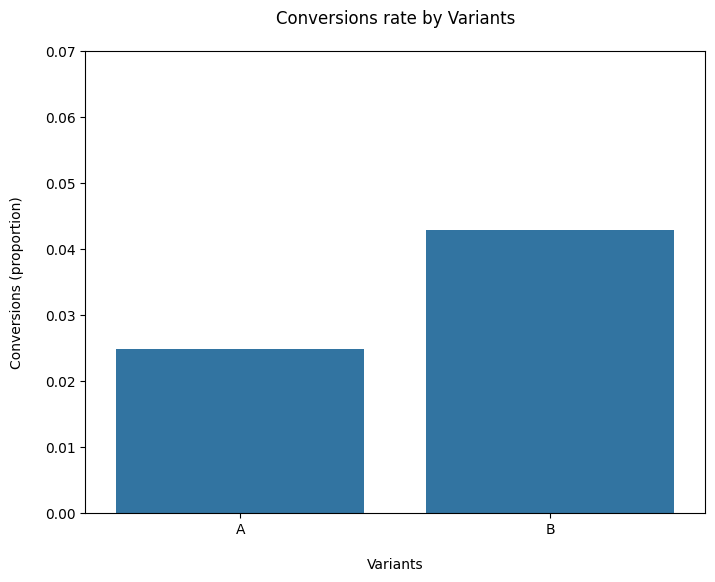

In [14]:
plt.figure(figsize=(8,6))

sns.barplot(x=ab_test['Variant'], y=ab_test['Conversions'], ci=False)

plt.ylim(0, 0.07)
plt.title('Conversions rate by Variants', pad=20)
plt.xlabel('Variants', labelpad=15)
plt.ylabel('Conversions (proportion)', labelpad=15)
# Save the plot using plt
plt.savefig('temp.png', dpi=300)

# Display the plot
plt.show()


The conversion rates for our groups are indeed very close. Also note that the conversion rate of the `control` group is lower than what we would have expected given what we knew about our avg. conversion rate (2.5% vs. 3.0%). 
In rea; case scenario this goes to show that there is some variation in results when sampling from a population.

So... the `treatment` group's value is higher. **Is this difference *statistically significant***?

***
## 4. Testing the hypothesis

The last step of our analysis is testing our hypothesis. Since we have a very large sample, we can use the <a href="https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval#Normal_approximation_interval">normal approximation</a> for calculating our $p$-value (i.e. z-test). 

Again, Python makes all the calculations very easy. We can use the `statsmodels.stats.proportion` module to get the $p$-value and confidence intervals:

In [15]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

In [16]:
control_results = ab_test[ab_test['Variant'] == 'A']['Conversions']
treatment_results = ab_test[ab_test['Variant'] == 'B']['Conversions']

In [17]:
n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.4f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: -3.52
p-value: 0.0004
ci 95% for control group: [0.019, 0.031]
ci 95% for treatment group: [0.035, 0.051]


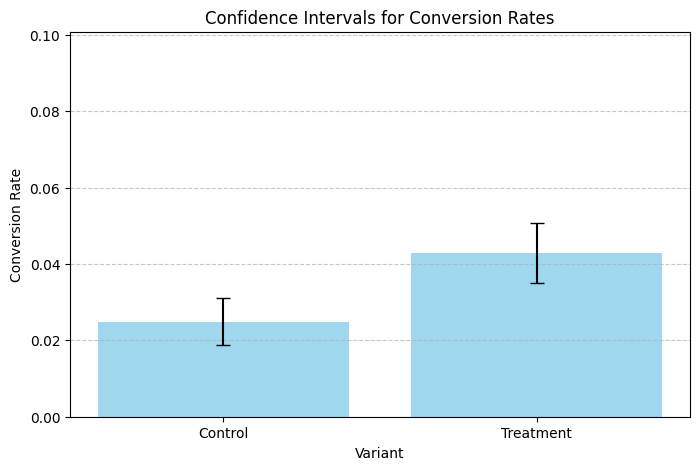

In [18]:
# Example data from your results
variants = ['Control', 'Treatment']
means = [control_results.sum() / n_con, treatment_results.sum() / n_treat]  # Conversion rates
ci_lower = [lower_con, lower_treat]
ci_upper = [upper_con, upper_treat]

# Calculate the error bars (difference between the means and the confidence bounds)
error_lower = [mean - lower for mean, lower in zip(means, ci_lower)]
error_upper = [upper - mean for upper, mean in zip(ci_upper, means)]

# Plot the confidence intervals
plt.figure(figsize=(8, 5))
plt.bar(variants, means, color='skyblue', yerr=[error_lower, error_upper], capsize=5, alpha=0.8)
plt.title('Confidence Intervals for Conversion Rates')
plt.ylabel('Conversion Rate')
plt.xlabel('Variant')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, max(ci_upper) + 0.05)  # Add some space above the largest upper bound

# Save the plot
plt.savefig('CI Comparison for Conversion Rates',dpi=300)

# Display the plot
plt.show()

The bar plot clearly highlights that the treatment group's variant performed better as well as the **confidence intervals for control and treatment are not overlapping**. This indicates that the observed difference is **statistically significant**, meaning the results are not due to random chance.

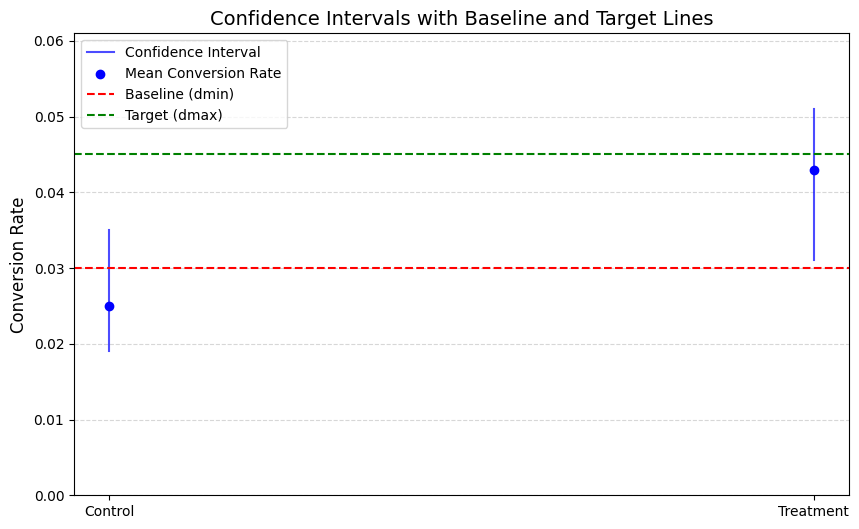

In [19]:
variants = ['Control', 'Treatment']
means = [0.025, 0.043]  # Example conversion rates for each group
ci_lower =  [0.019, 0.031]  # Lower bounds of confidence intervals
ci_upper = [0.035, 0.051]  # Upper bounds of confidence intervals
dmin = 0.030  # Example baseline rate
dmax = 0.045  # Example target rate

# Plot the conversion rates with confidence intervals
plt.figure(figsize=(10, 6))
for i in range(len(variants)):
    plt.plot([i, i], [ci_lower[i], ci_upper[i]], color='blue', alpha=0.7, label=None if i > 0 else 'Confidence Interval')
    plt.scatter(i, means[i], color='blue', label=None if i > 0 else 'Mean Conversion Rate', zorder=5)

# Highlight dmin and dmax as horizontal lines
plt.axhline(dmin, color='red', linestyle='--', label='Baseline (dmin)', linewidth=1.5)
plt.axhline(dmax, color='green', linestyle='--', label='Target (dmax)', linewidth=1.5)

# Add labels, title, and legend
plt.xticks(ticks=range(len(variants)), labels=variants)
plt.title('Confidence Intervals with Baseline and Target Lines', fontsize=14)
plt.ylabel('Conversion Rate', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(loc='upper left')
plt.ylim(0, max(ci_upper) + 0.01)  # Extend the y-axis for clarity

# Save the plot
plt.savefig('Baseline vs Target Lines(CI)',dpi=300)

# Show the plot
plt.show()

Note that the in the **Control Group**:  
- The mean conversion rate is slightly lower than **0.03** (baseline). 
- Conversion rate does not meet the target line **(dmax)**, but overlaps the baseline line 
**(dmin)**.


Meanwhile in the - **Treatment Group**:
- The mean conversion rate is noticeably higher, slightly above **0.04**, and closer to the target 
line **(dmax)**.
- Confidence interval spans roughly from **0.035 to 0.05**—**without overlapping** the baseline.
- This suggests improvement over the control group and a stronger alignment with the goal of 
reaching the target **(dmax)** conversion rate.


>**Inference**:  The treatment group shows higher effectiveness in increasing conversion rates than the control 
group. While the results suggest improvement, the **no overlap** in confidence intervals means the statistical 
significance need not to be evaluated further. 

## 5. Conclusion
Since our 
p-value=0.0004 is below our 
0.05, we can reject the null hypothesis 
, which means that our new design did perform significantly better than our old one 

Additionally, if we look at the confidence interval for the treatment group ([0.035, 0.051], i.e. 3.5-5.1%) we notice that:

It doesn't include our baseline value of 3% conversion rate
It includes our target value of 4.5% (the 1.5% uplift we were aiming for)
What this means is that it is more likely that the true conversion rate of the new design is better than our baseline.
This is further proof that our new design is likely to be an improvement on our old design.